# Прогнозирование оттока клиентов сети фитнес-центров

**Автор:**  

Григорьев Павел


**Описание проекта:**   

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов - отток клиентов. Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество клиентских анкет. Необходимо провести анализ и подготовить план действий по удержанию клиентов.   
А именно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;

**Цель:**  

Разработать стратегию удержания клиентов сети фитнес-центров на основе анализа данных, включая прогнозирование вероятности оттока, сегментацию клиентов и выявление ключевых факторов, влияющих на отток.

**Источники данных:**  

Данные предоставленны фитнес-центром. 

**Условия проведения анализа данных:**  


**Главные выводы:**  
тут помещаем самое главное из общего вывода, примерно до полустраницы, чтобы не было сильно много и при этом указать все главные выводы
Будет идеально, елси выводы на похожие темы будут рядом, то есть елси мы имеем несколько выводов о доходе, то лушче поместить их рядом

- Женщины чаще возвращают кредит, чем мужчины.
- Долги присутствуют у людей с разным доходом.


**Рекомендации:**

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.


## Загрузка библиотек <skip>

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import pagri_data_tools  # type: ignore
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

## Описание и изучение данных


### Описание данных


Данные клиента за предыдущий до проверки факта оттока месяц:
- gender - пол;
- Near_Location - проживание или работа в районе, где находится фитнес-центр;
- Partner - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends- факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- Phone - наличие контактного телефона;
- Age - возраст;
- Lifetime - время с момента первого обращения в фитнес-центр (в месяцах).
- Churn - факт оттока в текущем месяце;

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- Contract_period - длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- Month_to_end_contract - срок до окончания текущего действующего абонемента (в месяцах);
- Group_visits - факт посещения групповых занятий;
- Avg_class_frequency_total - средняя частота посещений в неделю за все время с начала действия абонемента;
- Avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц;
- Avg_additional_charges_total - суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

### Изучение данных


#### Изучение переменных


Загружаем данные и задаем типы данных для столбцов, где это возможно.

Сразу приведем все названия колонок к нижнему регистру.

In [2]:
dtype = {'gender': 'category', 'Near_Location': 'category', 'Partner': 'category', 'Group_visits': 'category', 'Churn': 'category'
         , 'Promo_friends': 'category', 'Phone': 'category'}
df = pd.read_csv('https://code.s3.yandex.net/datasets/gym_churn.csv', dtype=dtype)
df.columns = df.columns.str.lower()
df.sample(5, random_state=7)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2060,1,1,0,0,1,1,1,32,250.28,1.00,5,2.81,2.61,0
933,1,1,0,1,1,12,1,28,215.85,12.00,3,0.00,0.00,0
378,1,1,1,1,1,12,0,25,241.61,12.00,5,2.72,2.63,0
2754,1,1,0,0,1,1,1,32,150.54,1.00,1,3.01,2.80,0
596,1,1,0,0,1,6,1,28,176.98,6.00,5,2.65,2.72,0


Убедимся, что категориальные переменные имеют соответствующий тип данных.

In [3]:
df.dtypes

gender                               category
near_location                        category
partner                              category
promo_friends                        category
phone                                category
contract_period                         int64
group_visits                         category
age                                     int64
avg_additional_charges_total          float64
month_to_end_contract                 float64
lifetime                                int64
avg_class_frequency_total             float64
avg_class_frequency_current_month     float64
churn                                category
dtype: object

Изучим по отдельности каждый столбец.

In [4]:
gen = pagri_data_tools.info_gen(df)
gen.next()

Rows,Features,RAM (Mb),Duplicates,Dupl (sub - origin)
4.00k,14,0,---,---


Values,4.00k (100%),,Max,12.00,,Avg,4.68,,1.00 (55%)
Missing,---,,95%,12.00,,Mode,1.00,,12.00 (24%)
Distinct,3.00 (<1%),,75%,6.00,,Range,11.00,,6.00 (21%)
Duplicates,4.00k (99.9%),,50%,1.00,,iQR,5.00,,
Zeros,---,,25%,1.00,,std,4.55,,
Negative,---,,5%,1.00,,kurt,-1.15,,
RAM (Mb),<1 Mb,,Min,1.00,,skew,0.71,,

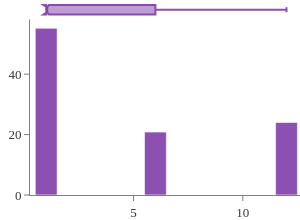

In [5]:
gen.next()

**Наблюдения:**  

- Больше половины клиентов имеют абонемент на 1 месяц. 24% - 12 месяцев, 21% - 6 месяцев.

Values,4.00k (100%),,Max,41.00,,Avg,29.18,,29.00 (12%)
Missing,---,,95%,34.00,,Mode,29.00,,30.00 (11%)
Distinct,23.00 (1%),,75%,31.00,,Range,23.00,,28.00 (11%)
Duplicates,3.98k (99.4%),,50%,29.00,,iQR,4.00,,31.00 (11%)
Zeros,---,,25%,27.00,,std,3.26,,27.00 (9%)
Negative,---,,5%,24.00,,kurt,-0.13,,32.00 (9%)
RAM (Mb),<1 Mb,,Min,18.00,,skew,-0.06,,26.00 (8%)

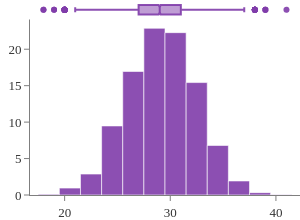

In [6]:
gen.next()

**Наблюдения:**  

- Клиенты имеют возраст от 18 до 41 года.
- В основном, клиенты имеют возраст от 27 до 31 года.

Values,4.00k (100%),,Max,552.59,,Avg,146.94,,14.23 <1%
Missing,---,,95%,323.44,,Mode,---,,17.08 <1%
Distinct,4.00k (100%),,75%,210.95,,Range,552.44,,278.20 <1%
Duplicates,---,,50%,136.22,,iQR,142.08,,120.46 <1%
Zeros,---,,25%,68.87,,std,96.36,,130.71 <1%
Negative,---,,5%,12.55,,kurt,0.00,,238.05 <1%
RAM (Mb),<1 Mb,,Min,0.15,,skew,0.62,,3.38 <1%

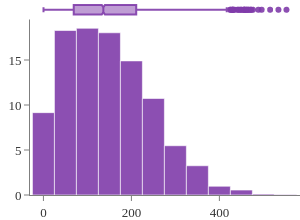

In [7]:
gen.next()

**Наблюдения:**  

- Суммарная выручка от других услуг лежит в диапазоне от 0.15 до 552.59.
- В основном, суммарная выручка от других услуг варьируется в диапазоне от 68.87 до 210.95.

Values,4.00k (100%),,Max,12.00,,Avg,4.32,,1.00 (55%)
Missing,---,,95%,12.00,,Mode,1.00,,6.00 (16%)
Distinct,12.00 (<1%),,75%,6.00,,Range,11.00,,12.00 (13%)
Duplicates,3.99k (99.7%),,50%,1.00,,iQR,5.00,,11.00 (5%)
Zeros,---,,25%,1.00,,std,4.19,,5.00 (3%)
Negative,---,,5%,1.00,,kurt,-0.91,,10.00 (2%)
RAM (Mb),<1 Mb,,Min,1.00,,skew,0.81,,9.00 (2%)

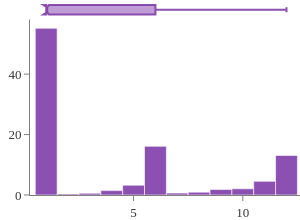

In [8]:
gen.next()

**Наблюдения:**  

- У 55% клиентов остался один месяц до завершения абонента.

Values,4.00k (100%),,Max,31.00,,Avg,3.72,,1.00 (21%)
Missing,---,,95%,11.00,,Mode,1.00,,2.00 (15%)
Distinct,29.00 (1%),,75%,5.00,,Range,31.00,,3.00 (12%)
Duplicates,3.97k (99.3%),,50%,3.00,,iQR,4.00,,0.00 (12%)
Zeros,487.00 (12%),,25%,1.00,,std,3.75,,4.00 (10%)
Negative,---,,5%,0.00,,kurt,5.27,,5.00 (7%)
RAM (Mb),<1 Mb,,Min,0.00,,skew,1.93,,6.00 (6%)

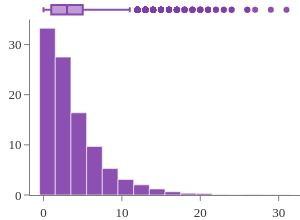

In [9]:
gen.next()

**Наблюдения:**  

- Время с первого обращения лежит в диапазоне от 0 до 31 месяца.
- В основном, время с первого обращения варьируется от 0 до 5 месяцев.
- Больше всего клиентов, которые первый раз пришли в фитнес-центр месяц назад (21%).

Values,4.00k (100%),,Max,6.02,,Avg,1.88,,0.00 (2%)
Missing,---,,95%,3.54,,Mode,0.00,,0.02 <1%
Distinct,3.91k (98%),,75%,2.54,,Range,6.02,,2.18 <1%
Duplicates,87.00 (2%),,50%,1.83,,iQR,1.36,,1.98 <1%
Zeros,88.00 (2%),,25%,1.18,,std,0.97,,1.67 <1%
Negative,---,,5%,0.29,,kurt,-0.22,,0.77 <1%
RAM (Mb),<1 Mb,,Min,0.00,,skew,0.25,,3.69 <1%

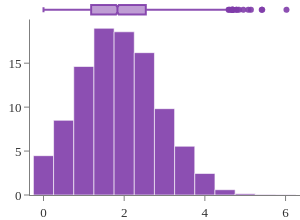

In [10]:
gen.next()

**Наблюдения:**  

- Среднее за все время число посещений в неделю лежит в диапазоне от 0 до 6.02.
- В основном, Среднее за все время число посещений в неделю варьируется от 1.18 до 2.54.
- 88 (2%) клиентов не посещали фитнес-центр ни разу.

Values,4.00k (100%),,Max,6.15,,Avg,1.77,,0.00 (5%)
Missing,---,,95%,3.55,,Mode,0.00,,1.33 <1%
Distinct,3.82k (96%),,75%,2.51,,Range,6.15,,2.63 <1%
Duplicates,180.00 (4%),,50%,1.72,,iQR,1.55,,1.80 <1%
Zeros,181.00 (5%),,25%,0.96,,std,1.05,,1.52 <1%
Negative,---,,5%,0.03,,kurt,-0.47,,1.31 <1%
RAM (Mb),<1 Mb,,Min,0.00,,skew,0.26,,2.14 <1%

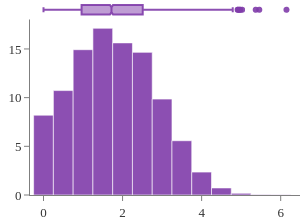

In [11]:
gen.next()

**Наблюдения:**  

- Среднее за последний время число посещений в неделю лежит в диапазоне от 0 до 6.15.
- В основном, Среднее за все время число посещений в неделю варьируется от 0.96 до 2.51.
- 181 (5%) клиентов не посещали фитнес-центр ни разу в этом месяце. Странно, так как это число больше, чем число клиентов, которые вообще не посещали ни разу.

Values,4.00k (100%),,1 (51%)
Missing,---,,0 (49%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

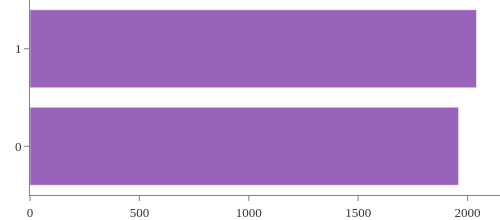

In [12]:
gen.next()

**Наблюдения:**  

- Пол распределен примерно поровну (51% на 49%)


Values,4.00k (100%),,1 (85%)
Missing,---,,0 (15%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

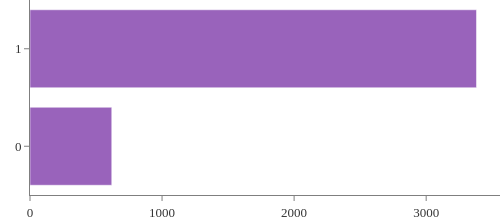

In [13]:
gen.next()

**Наблюдения:**  

- Клиентов, которые проживают или работают в райное фитнес-центра, больше всего (85%)

Values,4.00k (100%),,0 (51%)
Missing,---,,1 (49%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

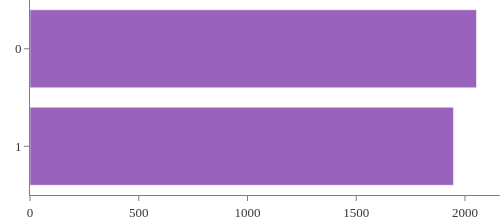

In [14]:
gen.next()

**Наблюдения:**  

- 49% клиентов являются сотрудниками компании-партнёра клуба.


Values,4.00k (100%),,0 (69%)
Missing,---,,1 (31%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

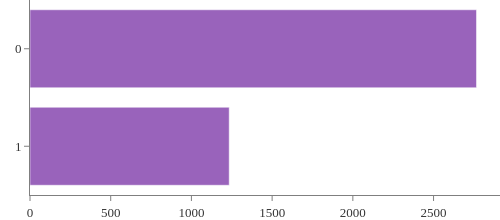

In [15]:
gen.next()

**Наблюдения:**  

- 31% клиентов первый раз записались по акции 'приведи друга'


Values,4.00k (100%),,1 (90%)
Missing,---,,0 (10%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

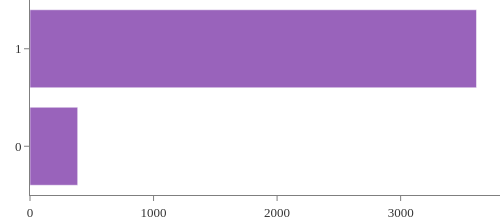

In [16]:
gen.next()

**Наблюдения:**  

- У большинства клиентов указан телефон (90%)


Values,4.00k (100%),,0 (59%)
Missing,---,,1 (41%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

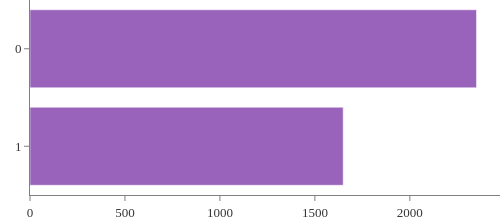

In [17]:
gen.next()

**Наблюдения:**  

- 41% клиентов посещали груповые занятия.


Values,4.00k (100%),,0 (73%)
Missing,---,,1 (27%)
Distinct,2.00 (<1%),,
Duplicated origin,4.00k (99.9%),,
Dupl (modify - origin),---,,
Empty,---,,
RAM (Mb),<1 Mb,,

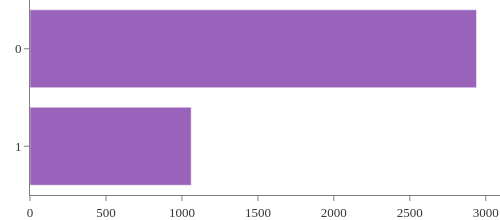

In [18]:
gen.next()

**Наблюдения:**  

- 27% клиентов числятся ушедшими.


Изучим средние значения для каждого показателя отдельно для ушедших и оставшихся клиентов.

In [19]:
churn_mean = df.astype({'gender': 'int', 'near_location': 'int', 'partner': 'int', 'group_visits': 'int', 'churn': 'int'
         , 'promo_friends': 'int', 'phone': 'int'}).pivot_table(columns='churn', aggfunc='mean', observed=True)
churn_mean['churn_feature_share'] = churn_mean[1] * 100 / churn_mean[0]
churn_mean.sort_values('churn_feature_share')

churn,0,1,churn_feature_share
lifetime,4.71,0.99,21.02
contract_period,5.75,1.73,30.08
month_to_end_contract,5.28,1.66,31.47
avg_class_frequency_current_month,2.03,1.04,51.51
promo_friends,0.35,0.18,51.99
group_visits,0.46,0.27,57.88
partner,0.53,0.36,66.52
avg_additional_charges_total,158.45,115.08,72.63
avg_class_frequency_total,2.02,1.47,72.84
near_location,0.87,0.77,87.98


**Наблюдения:**  

- У ушедших пользователей значительно ниже среднее количество месяцев с первого визита. Также значительно ниже длительность абонемента, количество месяцев до окончания абонемента. Также у ушедших заметно меньше доля пришедших по промоакции и среднее количество посещений за последний месяц.

#### Изучение дубликатов


Посмотрим на дубли во всем датафрейме


In [20]:
pagri_data_tools.check_duplicated(df)

'no duplicates'

В датафрейме полных строк дубликатов нет.

#### Изучение пропусков


Посмотрим на пропуски в каждом столбце

In [21]:
series_missed = pagri_data_tools.find_columns_with_missing_values(df)

There are no missing values


Пропусков не обнаружено.

#### Изучение выбросов


Посмотрим на выбросы используя квантили.    
Выбросами будем считать значения, которые выходят за пределы 5 и 95 квантилей.

Определение того, какой процент выбросов за пределами 5-го и 95-го квантилей можно считать "небольшим", может зависеть от контекста и специфики ваших данных. Однако, в общем случае можно использовать следующие ориентиры:

- 0% - 5%: Это обычно считается очень низким уровнем выбросов. Если процент выбросов находится в этом диапазоне, это может указывать на то, что данные достаточно чистые и не содержат значительных аномалий.
- 5% - 10%: Этот диапазон все еще может считаться приемлемым, особенно в некоторых областях, где небольшое количество выбросов является нормальным явлением.
- 10% - 20%: Это может быть признаком того, что в данных есть некоторое количество аномалий, и вам стоит обратить на них внимание. В зависимости от контекста, это может быть допустимо, но требует дальнейшего анализа.
- Более 20%: Это обычно считается высоким уровнем выбросов. Если процент выбросов превышает 20%, это может указывать на наличие значительных аномалий или проблем с данными, и вам следует провести более детальный анализ.

Важно посмотреть насколько одинаковые проценты выбросов в разных столбцах.  
Если процент примерно одинаковый, то это говорит об однородности данных.

In [22]:
series_outliers = pagri_data_tools.detect_outliers_quantile(df)

contract_period,0 (0.00%)
age,346 (8.65%)
avg_additional_charges_total,400 (10.00%)
month_to_end_contract,0 (0.00%)
lifetime,192 (4.80%)
avg_class_frequency_total,400 (10.00%)
avg_class_frequency_current_month,400 (10.00%)


**Наблюдения:**  

- В возрасте и времени с первого визита количество выбросов меньше 10%. Значит в этих столбцах нет существенных аномалий.
- В столбцах с выручкой от других услуг, средним количеством визитов в неделю за последний месяц и средним количеством визитов с первого появления 10% пропусков. Причем равное количество. Это подозрительно.

In [23]:
pagri_data_tools.analyze_anomaly_by_category(df, series_outliers, "by_category", "avg_additional_charges_total", "churn")

churn,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
0,2939,328,11.2%,82.0%,73.5%,8.5%
1,1061,72,6.8%,18.0%,26.5%,-8.5%


**Наблюдения:**
- У ушедших пользователей заметно меньше доля выбросов в выручке от других услуг.

In [24]:
pagri_data_tools.analyze_anomaly_by_category(df, series_outliers, "by_category", "avg_class_frequency_total", "churn")

churn,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
0,2939,342,11.6%,85.5%,73.5%,12.0%
1,1061,58,5.5%,14.5%,26.5%,-12.0%


**Наблюдения:**
- Ушедших пользователей заметно ниже доля выбросов в среднем числе посещений с начала посещений.

In [25]:
pagri_data_tools.analyze_anomaly_by_category(df, series_outliers, "by_category", "avg_class_frequency_current_month", "churn")

churn,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
0,2939,257,8.7%,64.2%,73.5%,-9.2%
1,1061,143,13.5%,35.8%,26.5%,9.2%


**Наблюдения:**
- У ушедших пользователей доля выбросов в количестве посещений в неделю за последний месяц заметно выше.

Посмотрим в одних и тех же ли строках выбросы в колоноках с выручкой от других услуг, средним количеством визитов в неделю за последний месяц и средним количеством визитов с первого появления

In [26]:
avg_additional_charges_total_indexes = series_outliers.avg_additional_charges_total.index
avg_class_frequency_total_indexes = series_outliers.avg_class_frequency_total.index
avg_class_frequency_current_month_indexes = series_outliers.avg_class_frequency_current_month.index

In [27]:
np.intersect1d(avg_additional_charges_total_indexes, avg_class_frequency_total_indexes)

array([  20,   92,  180,  761,  778,  865,  995, 1015, 1026, 1113, 1214,
       1249, 1265, 1305, 1320, 1326, 1825, 1860, 1924, 1944, 2029, 2059,
       2183, 2248, 2253, 2267, 2276, 2394, 2399, 2419, 2521, 2539, 2570,
       2600, 2662, 2892, 2992, 3008, 3010, 3088, 3192, 3427, 3549, 3662,
       3663, 3686, 3740, 3785, 3957])

Гипотеза, что выбросы в одних и тех же строках не подтвердилась.

#### Изучение отрицательных значений


Изучим отрицательные значения в каждом столбце.

In [28]:
series_negative = pagri_data_tools.find_columns_with_negative_values(df)

There are no negative values


Отрицательных значений не обнаружено.

#### Изучение нулевых значений


Изучим нулевые значения в каждом столбце.

In [29]:
series_zeros = pagri_data_tools.find_columns_with_zeros_values(df)

lifetime,487 (12.17%)
avg_class_frequency_total,88 (2.20%)
avg_class_frequency_current_month,181 (4.52%)


В lifetime нули могут означать, что пользователь пришел в этом месяце. Также нули могут означать, что пользователь ушел в первый месяц.

In [30]:
pagri_data_tools.analyze_anomaly_by_category(df, series_zeros, "by_category", "lifetime", "churn")

churn,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
0,2939,84,2.9%,17.2%,73.5%,-56.2%
1,1061,403,38.0%,82.8%,26.5%,56.2%


**Наблюдения:**
- У ушедших пользователей доля нулей в lifetime значительно выше.

In [31]:
pagri_data_tools.analyze_anomaly_by_category(df, series_zeros, "sample", "avg_class_frequency_total", "None")

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
13,1,1,0,0,1,1,1,27,152.748668,1.000000,1,0.000000,0.000000,1
31,0,1,0,0,1,12,1,32,87.856139,12.000000,1,0.000000,0.000000,0
3096,0,1,0,0,1,1,0,31,133.209579,1.000000,3,0.000000,0.000000,1
3049,0,1,0,0,1,6,1,33,84.251487,6.000000,0,0.000000,0.090099,0
3008,0,1,1,0,1,1,1,33,1.401597,1.000000,3,0.000000,0.000000,0
2982,0,1,0,0,1,1,1,30,90.109341,1.000000,1,0.000000,0.082645,0
2934,0,1,0,0,1,12,0,29,219.144673,12.000000,4,0.000000,0.181012,0
2933,0,1,1,0,0,1,0,31,75.698902,1.000000,13,0.000000,0.177691,0
2860,0,1,1,0,1,6,0,30,88.035036,6.000000,4,0.000000,0.149429,0
2818,0,1,1,1,1,6,1,27,70.130597,6.000000,1,0.000000,0.066074,0


**Наблюдения:**
- Пользователи с нулями в поле количество посещений в неделю с первого визита принесли выручку по другим услугам.

In [32]:
pagri_data_tools.analyze_anomaly_by_category(df, series_zeros, "by_category", "avg_class_frequency_current_month", "churn")

churn,total,count,count_in_total_pct,count_in_sum_count_pct,total_in_sum_total_pct,diff_sum_pct
0,2939,47,1.6%,26.0%,73.5%,-47.5%
1,1061,134,12.6%,74.0%,26.5%,47.5%


**Наблюдения:**
- Ушедшие пользователи имеют значительно большую долю нулей в количестве посещений в неделю за последний месяц.

Посмотрим на пользователй, которые не посещали ни разу, но при этом за последний месяц у них не нулевое количество посещений.

In [33]:
df[(df.avg_class_frequency_total == 0) & (df.avg_class_frequency_current_month != 0)]

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
274,0,1,1,1,1,12,1,30,131.66,9.00,5,0.00,0.09,0
449,1,1,1,1,1,1,1,26,247.75,1.00,1,0.00,0.14,0
756,0,1,0,0,1,1,0,30,52.87,1.00,0,0.00,0.00,0
1163,1,1,1,0,1,12,1,28,21.95,12.00,3,0.00,0.02,0
1197,1,1,1,1,0,12,0,28,64.70,12.00,8,0.00,0.07,0
1313,0,1,0,1,1,6,1,30,51.28,6.00,2,0.00,0.05,0
1683,0,1,1,0,1,1,1,27,234.30,1.00,17,0.00,0.01,0
1689,1,1,1,0,1,6,0,29,302.31,6.00,0,0.00,0.06,0
1983,0,1,1,0,1,6,0,34,148.68,6.00,2,0.00,0.00,0
2049,0,1,1,1,1,12,1,30,102.70,12.00,9,0.00,0.01,0


**Наблюдения:**  

- Есть пользователи, у которых среднее количество визитов за все время равно нулю, а за последнюю неделю не равно нулю. Это странно. Возможно среднее количество визитов в неделю за все время имеет больше 2 знаков после запятой и округлилось.

### Промежуточный вывод


- Больше половины клиентов имеют абонемент на 1 месяц. 24% - 12 месяцев, 21% - 6 месяцев.
- Клиенты имеют возраст от 18 до 41 года.
- В основном, клиенты имеют возраст от 27 до 31 года.
- Суммарная выручка от других услуг лежит в диапазоне от 0.15 до 552.59.
- В основном, суммарная выручка от других услуг варьируется в диапазоне от 68.87 до 210.95.
- У 55% клиентов остался один месяц до завершения абонента.
- Время с первого обращения лежит в диапазоне от 0 до 31 месяца.
- В основном, время с первого обращения варьируется от 0 до 5 месяцев.
- Больше всего клиентов, которые первый раз пришли в фитнес-центр месяц назад (21%).
- Среднее за все время число посещений в неделю лежит в диапазоне от 0 до 6.02.
- В основном, Среднее за все время число посещений в неделю варьируется от 1.18 до 2.54.
- 88 (2%) клиентов не посещали фитнес-центр ни разу.
- Среднее за последний время число посещений в неделю лежит в диапазоне от 0 до 6.15.
- В основном, Среднее за все время число посещений в неделю варьируется от 0.96 до 2.51.
- 181 (5%) клиентов не посещали фитнес-центр ни разу в этом месяце. Странно, так как это число больше, чем число клиентов, которые вообще не посещали ни разу.
- Пол распределен примерно поровну (51% на 49%)
- Клиентов, которые проживают или работают в райное фитнес-центра, больше всего (85%)
- 49% клиентов являются сотрудниками компании-партнёра клуба.
- 31% клиентов первый раз записались по акции 'приведи друга'
- У большинства клиентов указан телефон (90%)
- 41% клиентов посещали груповые занятия.
- 27% клиентов числятся ушедшими.
- У ушедших пользователей значительно ниже среднее количество месяцев с первого визита. Также значительно ниже длительность абонемента, количество месяцев до окончания абонемента. Также у ушедших заметно меньше доля пришедших по промоакции и среднее количество посещений за последний месяц.
- В возрасте и времени с первого визита количество выбросов меньше 10%. Значит в этих столбцах нет существенных аномалий.
- В столбцах с выручкой от других услуг, средним количеством визитов в неделю за последний месяц и средним количеством визитов с первого появления 10% пропусков. Причем равное количество. Это подозрительно.
- У ушедших пользователей заметно меньше доля выбросов в выручке от других услуг.
- У ушедших пользователей заметно ниже доля выбросов в среднем числе посещений с начала посещений.
- У ушедших пользователей доля выбросов в количестве посещений в неделю за последний месяц заметно выше.
- У ушедших пользователей доля нулей в lifetime значительно выше.
- Пользователи с нулями в поле количество посещений в неделю с первого визита принесли выручку по другим услугам.
- Ушедшие пользователи имеют значительно большую долю нулей в количестве посещений в неделю за последний месяц.
- Есть пользователи, у которых среднее количество визитов за все время равно нулю, а за последнюю неделю не равно нулю. Это странно. Возможно среднее количество визитов в неделю за все время имеет больше 2 знаков после запятой и округлилось.


## Предобработка данных


Изучив данные, можно сделать вывод, что данные достаточно чистые.  
Пропусков нет, отрицательных значений нет. Есть нулевые значения, но в тех колонках, где нули могут быть в действительности.  
Обработка данных не требуется.

Преобразуем тип данных из float в int в столбцах, где целые значения.

In [34]:
df.dtypes

gender                               category
near_location                        category
partner                              category
promo_friends                        category
phone                                category
contract_period                         int64
group_visits                         category
age                                     int64
avg_additional_charges_total          float64
month_to_end_contract                 float64
lifetime                                int64
avg_class_frequency_total             float64
avg_class_frequency_current_month     float64
churn                                category
dtype: object

Нужно преобразовать столбец month_to_end_contract в целый тип.

Убедимся, что в столбце нет дробных чисел.

In [35]:
(df.month_to_end_contract % 1 != 0).sum()

np.int64(0)

In [36]:
df.month_to_end_contract = df.month_to_end_contract.astype('int32')
df.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0


In [37]:
df.month_to_end_contract.dtype

dtype('int32')

## Визуализация взаимосвязей переменных


### Сравнительный анализ распределений числовых переменных

Изучим как распределены числовые переменные между группами.

Сормируем словарь для подписей осей и названий графиков.

In [73]:
titles_for_axis = dict(
    # numeric column ['Именительный падеж', 'для кого / чего']
    age = ['Возраст', 'возраста']
    , avg_class_frequency_total = ['Среднее число посещений в неделю за все время', 'среднего числа посещений в неделю за все время']
    , avg_class_frequency_current_month = ['Среднее число посещений в неделю за последний месяц', 'среднее числа посещений в неделю за последний месяц']
    , lifetime = ['Время с момента первого посещения', 'времени с момента первого посещения']
    , avg_additional_charges_total = ['Суммарная выручка от других услуг', 'суммарной выручки от других услуг']
    , contract_period = ['Длительность абонемента', 'длительности абонемента']
    , month_to_end_contract = ['Срок до конца абонемента', 'срока до конца абонемента']    
    # categorical column ['Именительный падеж', 'для кого / чего']
    , gender = ['Пол', 'пола']
    , near_location = ['Проживание или работа в районе', 'проживания или работы в районе']
    , partner = ['Сотрудник компании-партнёра', 'сотрудника компании-партнёра']
    , promo_friends = ['Пришел по промо', 'пришедшего по промо']    
    , phone = ['Наличие телефона', 'наличия телефона']    
    , group_visits = ['Посешял групповые занятия', 'посешения групповых занятий']    
    , churn = ['Факт оттока', 'факта оттока']    
)

In [ ]:
config = dict(
    df = df
    , cat_var = 'churn'
    , num_var = 'age'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=30
    , line_width=3
    , opacity = 0.6
    , barmode='overlay'
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

**Наблюдения:**  

- У ушедших пользователей возраст ниже, чем у оставшихся.

In [ ]:
config = dict(
    df = df
    , cat_var = 'churn'
    , num_var = 'avg_class_frequency_total'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=30
    , line_width=3
    , opacity = 0.6
    , barmode='overlay'
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

**Наблюдения:**  

- У ушедших пользователей среднее число посещений в неделю за все время ниже, чем у оставшихся пользователей. И разброс значений у ушедших пользователей меньше.

In [ ]:
config = dict(
    df = df
    , cat_var = 'churn'
    , num_var = 'avg_class_frequency_current_month'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=30
    , line_width=3
    , opacity = 0.6
    , barmode='overlay'
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

**Наблюдения:**  

- У ушедших пользователей среднее число посещений в неделю за последний месяц ниже, чем у оставшихся пользователей. И разброс значений у ушедших пользователей меньше.

In [ ]:
config = dict(
    df = df
    , cat_var = 'churn'
    , num_var = 'lifetime'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=40
    , line_width=3
    , opacity = 0.6
    , barmode='overlay'
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

**Наблюдения:**  

- У ушедших пользователей время с момента первого обращения ниже, чем у оставшихся пользователей.

In [ ]:
config = dict(
    df = df
    , cat_var = 'churn'
    , num_var = 'avg_additional_charges_total'
    , top_n=3
    , lower_quantile=0
    , upper_quantile=1
    , bins=30
    , line_width=3
    , opacity = 0.6
    , barmode='overlay'
)
pagri_data_tools.histograms_stacked(config=config, titles_for_axis=titles_for_axis)

**Наблюдения:**  

- У ушедших пользователей суммарная выручка от других услуг меньше, чем у оставшихся.

In [64]:
config = dict(
    df = df
    , column_for_axis = 'contract_period'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- С ростом длительности абонемента доля ушедших пользователей снижается. У пользователей с абонементом на 12 месяцев доля ушедших всего 2.4%.

In [70]:
config = dict(
    df = df
    , column_for_axis = 'month_to_end_contract'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Самая высокая доля ушедших со сроком до конца абонемента 1 месяц. То есть люди чаще ходят, когда абонемент скоро кончиться. При этом доля ушедших пользователей со скроком до конца абонемента больше 6 месяцев минимальная. Также низкая доля ушедших у пользователей со сроком 3 месяца.

### Сравнительный анализ распределений категориальных переменных

In [ ]:
config = dict(
    df = df
    , column_for_axis = 'gender'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Пол практически не влияет на факт оттока клиента.

In [ ]:
config = dict(
    df = df
    , column_for_axis = 'near_location'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Доля ушедших выше у клиентов, которые не проживают или работают в районе фитнес-центра.

In [ ]:
config = dict(
    df = df
    , column_for_axis = 'partner'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Доля ушедших више у клиентов, которые не являются сотрудниками компании-партнера.

In [ ]:
config = dict(
    df = df
    , column_for_axis = 'promo_friends'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Доля ушедших ниже у клиентов, которые пришли по промо акции.

In [ ]:
config = dict(
    df = df
    , column_for_axis = 'phone'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Наличие телефона не влияет на факт оттока клиента.

In [84]:
config = dict(
    df = df
    , column_for_axis = 'group_visits'
    , column_for_legend = 'churn'  
    , barmode = 'group'
    , orientation = 'v'
    , normalized_mode = 'row'
    , height = 450
    , width = 1000
    , text = False
    , xaxis_show = True
    , yaxis_show = True
    , showgrid_x = False
    , showgrid_y = True      
    , sort_axis = True    
    , sort_legend = True    

)
pagri_data_tools.bar_categories(config, titles_for_axis)

**Наблюдения:**  

- Доля ушедших выше у клиентов, которые не посещали групповые занятия.

### Исследование корреляционных связей

Сормируем словарь для подписей осей и названий графиков.

In [ ]:

titles_for_axis= dict(
    age = 'Возраст'
    , avg_class_frequency_total = 'Ср число посещений в неделю за все время'
    , avg_class_frequency_current_month = 'Среднее число посещений в неделю за последний месяц'
    , lifetime = 'Время с момента первого посещения'
    , avg_additional_charges_total = 'Суммарная выручка от других услуг'
    , contract_period = 'Длительность абонемента'
    , month_to_end_contract = 'Срок до конца абонемента'
    , gender = 'Пол'
    , near_location = 'Проживание или работа в районе'
    , partner = 'Сотрудник компании-партнёра'
    , promo_friends = 'Пришел по промо'
    , phone = 'Наличие телефона'
    , group_visits = 'Посешял групповые занятия'
    , churn = 'Факт оттока'
)

Посмотрим на коэффициенты корреляции между числовыми переменными.

In [ ]:
pagri_data_tools.heatmap_corr(df, titles_for_axis=titles_for_axis)

Лучше лишние ячейки убирать, если есть возможность 

In [ ]:
pagri_data_tools.heatmap_corr(df_by_userid_month[['sessions_per_day', 'calls_per_day']])

Если нужно быстро просмотреть, то проганяем в цикле

In [ ]:
for key, df in dict(
            df_users = df_users
            , df_calls = df_calls
            , df_messages = df_messages
            , df_internet = df_internet
            , df_tariffs = df_tariffs
            , df_calls_full = df_calls_full
            , df_messages_full = df_messages_full
            , df_internet_full = df_internet_full
            , df_by_userid_month = df_by_userid_month
            , df_arpu = df_arpu).items():
    print(key)
    display(pagri_data_tools.heatmap_corr(df))

Если переменных много и нужно разделить на части, то используем эту функцию 

In [ ]:
gen = pagri_data_tools.heatmap_corr_gen(df, part_size=10, titles_for_axis=titles_for_axis)
next(gen)

### Изучение зависимостей между числовыми переменными


Построим дендогрммы для числовых переменных.

Если данных много, то делаем сэмплирование.

In [ ]:
sampled_df = df.sample(n=10, random_state=42)  # random_state для воспроизводимости

Дендограммы можно использовать в анализе данных без машинного обучения для визуализации иерархической структуры данных, определения оптимального числа кластеров и выявления выбросов. Они помогают исследовать скрытые закономерности и взаимосвязи в данных, что делает их полезными в различных контекстах. Рассмотрим основные случаи использования дендограмм в анализе данных:

- Визуализация иерархической структуры:  
Дендограммы позволяют визуально представить, как объекты или наблюдения группируются в кластеры на разных уровнях иерархии. Это помогает понять, какие элементы имеют схожие характеристики.
- Определение числа кластеров:  
Анализ высоты соединений в дендограмме может помочь определить оптимальное количество кластеров. Это особенно полезно, когда заранее неизвестно, сколько кластеров следует выделить.
- Анализ расстояний между объектами:  
Дендограммы показывают расстояния между кластерами, что позволяет оценить степень сходства или различия между группами данных.
- Выявление выбросов:   
Дендограммы могут помочь в обнаружении выбросов. Если отдельные наблюдения объединяются с другими на значительно большом расстоянии, это может указывать на их аномальность.
- Сравнение различных наборов данных:  
Дендограммы могут быть использованы для сравнения различных наборов данных или методов анализа. Это позволяет визуально оценить, как разные данные или методы приводят к различным результатам.
- Исследовательский анализ данных:  
Дендограммы могут быть полезны в исследовательском анализе данных для выявления скрытых закономерностей и взаимосвязей, что может привести к новым гипотезам и направлениям для дальнейшего анализа.

In [ ]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

# Пример данных
data = {
    'Feature1': [1.0, 2.0, 1.5, 8.0, 8.5, 9.0],
    'Feature2': [1.0, 1.5, 1.2, 8.0, 8.5, 9.0],
    'Category': ['A', 'A', 'A', 'B', 'B', 'B']  # Категориальный признак
}

df = pd.DataFrame(data)

# Выбор числовых признаков
numerical_data = df[['Feature1', 'Feature2']]

# Стандартизация данных
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Вычисление иерархической структуры для дендограммы
linked = linkage(numerical_data_scaled, method='ward')

# Построение дендограммы с использованием Plotly
fig = ff.create_dendrogram(linked, orientation='bottom')
fig.update_layout(title='Dendrogram for Numerical Features',
                  xaxis_title='Distance',
                  yaxis_title='Observations',
                  width=800,
                  height=600, 
                  )
fig.show()

Построим графики рассеяния и изучим зависимости.


ВАЖНО  
Изучаем зависимости между числовыми переменными без фильтрации и с фильтрацией.  
То есть нужно взять и пройти по каждой категории и посмотреть на зависимости в каждой категории.  
Возможно даже в комбинации категорий.  
Так как в общей картинке зависимости могут затеряться.

ВАЖНО смотрим на выбросы  
Мы могли при изучении отдельных столбцов не заметить их, если заметили, то возвращаемся в изучение и предобработку и изучаем их дополнительно

In [ ]:
pairs = {('total_images', 'last_price'): None, ('total_images', 'floors_total'): {'total_images': [-2.15, 22.45], 'floors_total': [0.51, 28.54]}, ('total_images', 'kitchen_area'): {'total_images': [-1.04, 28.44], 'kitchen_area': [-0.6, 59.26]}, ('total_images', 'parks_nearest'): {'total_images': [np.int64(0), np.int64(50)], 'parks_nearest': [np.float64(1.0), np.float64(3190.0)]}, ('total_images', 'ponds_around3000'): {'total_images': [np.int64(0), np.int64(50)], 'ponds_around3000': [np.float64(0.0), np.float64(3.0)]}, ('total_images', 'living_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'living_total_ratio': [np.float64(0.02), np.float64(1.0)]}, ('total_images', 'kitchen_total_ratio'): {'total_images': [np.int64(0), np.int64(50)], 'kitchen_total_ratio': [np.float64(0.03), np.float64(0.79)]}, ('total_images', 'price_per_sqm'): {'total_images': [np.int64(0), np.int64(50)], 'price_per_sqm': [np.int64(7962), np.int64(1907500)]}, ('last_price', 'living_area'): {'last_price': [np.int64(430000), np.int64(763000000)], 'living_area': [np.float64(2.0), np.float64(427.55)]}}
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3).show(config=dict(displayModeBar=False, dpi=200), renderer="png")
# если нужно интерактивый график, то
pagri_data_tools.pairplot_pairs(df, pairs, coloring=True, horizontal_spacing=0.12, rows=3, cols=3)

Чтобы в dash app выбрать нужные пары для scatterplot   
ставим  `_gen_` в месте где хотим чтобы появились ячейки с кодом для постройки графиков      
далее используем  `pagri_dash.scatterplot_analysis_dash`

In [ ]:
_gen_ 

ВАЖНО  
убираем лишние колонки, которые нам не нужно изучать, например, id, и другие числовые переменные, которые будут только тратить место в dash app

In [ ]:
df_by_userid_month.drop(['user_id', 'messages_included'], axis=1)

In [ ]:
import sys
sys.path.append('/home/pagri/git_repos/pagri_private_modules')
import pagri_dash
pagri_dash.scatterplot_analysis_dash(df, "path/to/notebook/for/save")

## Общий вывод


ВАЖНО  
проверить, что результат проверки гипотез учтен в выводах.  
То есть если у нас был промежуточный вывод, но проверка гипотез опровергла этот вывод, то нужно изменить вывод на противоположный.

Проходим собираем все промежуточные выводы, вставляем сюда и выбираем важные. 

ВАЖНО  
из промежуточных выводов в изучении данных собрать подобные выводы:  
- Рынок жилья представлен объектами общей площадью от 12 до 900 кв.м. В основном это жилье от 30 до 100 кв.м. с пиком в сегменте 30-75 кв.м. В жилой площади квартиры преобладает диапазон 15-50 кв.м. Размер площади кухни-от 5 до 15 кв.м., с пиком 9 кв.м. Это стандартные небольшие квартиры эконом-класса. Подавляющее большинство квартир- 1-3 комнатные, с высотой потолка 2,6-2,7 м., но встречаются редкие варианты до 19 комнат и высотой потолка до 20 кв.м. (либо ошибка, либо свободная планировка с возможностью многоуровневости).
- Цены на квартиры в основном находятся в диапазоне 2.5-15 млн.руб. с пиком в области 3-5 млн.руб.(небольшие квартиры эконом-класса), но есть и уникальные объекты стоимостью до 763 млн.руб. Стоимость квадратного метра недвижимости варьируется от 50-130 тыс.руб. с пиком в 90-100 тыс.руб. Наряду с типовыми предложениями на продажу выставлено жилье премиум-класса со стоимостью 1 кв.м. до 1.9 млн.руб.
- Общее время продажи жилой недвижимости-до 1618 дней. Половина квартир продается за период до 94 дней, а среднее значение по всему массиву данных -185 дней. При этом можно увидеть, что пик продаж приходится на 45-60 день с момента публикации. Исходя из расчета выбросов можно сказать, что продажи прошли аномально быстро, если сделки были оформлены в период до 16 дней и слишком долго, если до оформления сделки свыше 1134 дней.    

Это важно, так как дает представление о данных в сжатой и удобной форме.  
А далее уже идут выводы о зависимостях.  

Не забываем ставить 2 пробела после Выводы и другие для quarto

После каждой строки поставить либо перенос, либо 2 пробела для quarto  
так как когда следующая строка начинается с дефиса и jupyter это понимает и делает новую строку,   
то quarto не сделает новую строку

**Выводы:**  


- Долги есть у людей с разным доходом.  
- У должников в среднем больше детей.  
- У должников среднее количество детей больше у женщин, а у не должников срднее количество детей больше у мужчин  
- У должников средний возраст немного ниже для всех категорий семейного положения.  
- Медианный доход у должников и не должников практически не отличается  
- Должники имеют ниже средний возраст как мужчины так и женщины. Ситуация сохраняется во всех группах дохода.  
- Цель получения кредита практически не зависит от среднего ежемесяченого дохода.  
- 92 % клиентов не имеют долга.  
- Люди от 30 до 50 лет имеют самый высокий средний доход.  
- Больше всего кредит берут на цели, связанные с недвижимостью, кроме людей в гражданском браке  
- Люди в гражданском браке чаще берут кредит на свадьбу  
- Женщины чаще возвращают кредит.  
- Анализ значимости признаков для модели случайного леса показал, что доход является самым значимым признаком для предсказания задолженности.  
- 58 % клиентов либо женаты, либо замужем. 19 % в гражданском браке. Можно сделать вывод что большинство в браке.  
- Большинство клиентов женщины (66 процентов).  
- Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.  
- Чем меньше количество детей, тем больше значений с высоким доходом.  
- Болшая часть женатых имеет доход 100-200 тыс  
- На всех уровнях образоания, кроме ученой степени, доход у мужчин выше.  
- У мужчин, которые в браке или были в браке, количество детей больше, чем у женщин в той же категории.  


**Аномалии и особенности в данных:**  

- В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  
- В столбце с количеством детей есть отрицательные значения. 47 штук. Меньше 1 процента от всего датафрейма. Также есть клиенты с 20 детьми.  
- Колонока общий трудовой стаж содержит 74 % отрицаетльных значений. А также максимальное количество дней стажа больше 400 тысяч дней, это больше 1000 лет.  
- В колонке возраста 101 нулевое значени.  
- Колонка дохода имеет слишком много знаков после запятой.  
- В колонке с образованием присутствуют одни и те же знчения с разными регистрами. При этом в колонке с id образования все впрорядке.  


ВАЖНО  
в результаты предобработки добавляем также выводы из раздела про создание новых переменных и обогащение таблиц

**Результаты предобработки данных:**  

- Удалили колонки с id образования и семейного статуса, так как нам для графиков лучше подойдут названия, а не id.
- Колонка со стажем имеет совершенно некорректные данные. Чтобы не внести искажение в анализ, удалим эту колонку.


**Результаты проверки гипотез:**  

- Гипотеза 1: Средняя выручка с пользователя не зависит от возрастной группы.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что возрастная группа оказывает статистически значимое влияние на среднюю выручку с пользователя.
- Гипотеза 2: Средняя выручка между тарифами Smart и Ultra не отличается.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что выручка от тарифа Smart статистически значимо выше, чем от тарифа Ultra.
- Гипотеза 3: Средняя выручка с пользователя не зависит от месяца.  
**Результат:** На уровне значимости 0.05 гипотеза была отклонена.  
Это указывает на то, что месяц оказывает статистически значимое влияние на среднюю выручку с пользователя.
- Гипотеза 4: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
**Результат:** На уровне значимости 0.05 нет оснований отвергнуть гипотезу.


ВАЖНО  
Используем ИИ для формулирования рекомендаций. Сначала кидаем ему описание проекта и цель и далее кидаем общие выводы и просим написать рекомендации.

**Рекомендации:**  

- Добавить контроль данных, чтобы не дублировались значения с разными регистрами в колонке с образованием.
- Добавить уникальный идентификатор клиента, чтобы избежать дублирования строк.
- Добавить проверку на отрицательные значения и на слишком болшьшие значения в количестве детей при загрузке данных.
- Выяснить откуда возникают отрицательные значения в трудовом стаже и добавить контроль ввода невалидных данных.
- Выяснить причину нулевых значений в колонке возраста и добавить проверку на нулевые значения при загрузке данных.
- Выяснить причину большого количества знаков после запятой в колонке дохода.


ВАЖНО   
ячейки далее лучше удалить до обработки ноутбука, чтобы не было ошибок  
Копировать что нужно можно из шаблона

> Что нужно сообщить в выводе

- информацию о том, что удалось подтвердить гипотезы (тут пишем только те, которые удалось подтвердить)
- всю информацию о датасете, которые важны. Дубликаты, которые несут практическую пользу и рекомендации по ним, пропуски также с рекомендациями
  > и остальные моменты по данным и рекомендации. Тут важно указывать именно найденные аномалии, которые имеют практическую пользу, которые нужно исправить и прочее.  
  > Пишем, что были найдены выбросы, они были связаны возможно с тем то и тем то.
- и в конце обязательно call to action
  > написать что необходимо сделать с этими результатами


> Советы по оформлению общего выывод

- не нужно вставлять таблицы и графики в вывод.
  > В выводе пишем словами самое важное и практически полезное, что мы получили, причем в порядке убывания важности.  
  > И когда мы пишем, что увидели то-то, то приводим гиперссылку на график или результат ячейки, где это получено.  
  > Так будет компактный вывод и при необходимости человек сможет быстро перейти и посмотреть график или таблицу


**Удалось подтвердить гипотезу** о влиянии различных характеристик клиента на факт погашения кредита в срок. Каждый из рассмотренных параметров оказывает влияние на надёжность заёмщика. Рассмотренные факторы по-разному влияют на надёжность заёмщиков. Например, семейное положение оказалось более значимым фактором, чем уровень дохода.


- В ходе анализа исходного набора данных было проведено (были устранены пропуски в двух колонках с числовыми значениями - 'total_income' и 'days_employed').
- После **устранения явных и скрытых дупликатов** и удаления оставшихся после обогащения пропусков объем датасета сократился на 0.05%
- Были устранены **выбросы** в колонках 'days_employed' и 'children': в первом случае выбросы возникли в результате системной ошибки (данные были внесены в часах, а не в днях); во втором случае ошибка, вероятнее всего была допущена людьми, вносившими данные в систему
- ...


**Необходимо**


> 1.  Запросить в отделе по работе с клиентами информацию о возможности брать кредит без подтверждения дохода.
>
> 2.  Сообщить коллегам, занимающимся выгрузкой о наличие дубликатов, если вопрос не разрешится, запросить индентификационный номер клиента к датасету.
>
> 3.  Прописать в задаче на поставку данных формат данных (пол только F и M, положительные значения). Приложить информацию о найденных аномалиях.


**Сначала проверяем орфографические ошибки**


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.correct_notebook_text(notebook_path)

**Затем создаем номера у глав и оглавление**


> Чтобы добавить номера глав и ссылки для оглавления и сделать оглавлнеие  
> оглавление добавиться в начало ноутбука


> Сначала можно в режиме `draft` сделать пробный варант, проверить и потом уже запустить в режиме `final`


In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.make_headers_link_and_toc(notebook_path)

**Далее создаем ссыки на выводы и аномалии**


Выбираем нужные выводы и нужный порядок выводов и добавляем их в список выводов и используем эту функцию

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
conclusions = [
    'С ноября 2017 по март 2018 тратилось много денег на компаню с id 3.'
    , 'Сумма заказа варируется от 0 до 2633.28 у.е.'
]
pagri_data_tools.add_conclusions(notebook_path, conclusions)

> Чтобы было удобно искать где вставить якорь для ссылки, названия выводов и аномалий должно точно совпадать  
> в итоговом списке аномалий и выводов и в тех местах (то есть в наблюдениях под ячейками), куда мы будем помещать ссылки


> Чтобы сделать ссылки на выводы и аномалии, нужно  
> в тех местах, куда хотим переходить по ссылке вставить текст выводов или аномалий (берем прямо из основных выводов)  
> выводы должны начинаться с `_conclusion_`  
> аномалии должны начинаться с `_anomalies_`  
> Примеры:  
>


Окончательный текст выводов можно будет потом исправить в выводах всего отчета и поместить их в начало,  
важно, выводы не менять до момента, пока мы не создадим ссылки на них.  
Чтобы автомтика не нарушилась.  
Затем можно будет исправить уже сам текст выводов и это не нарушит ссылки.

In [ ]:
==== _anomalies_ В столбце с количеством детей есть отрицательные значения. 47 штук. 

> Можно в одной ячейке и выводы и аномалии, с обеих ссылок будет переходить сюда, но назад будет возвращаться только в одно место,  
> в то, которое было первым в ячейке


ВАЖНО  
разобраться почему когда рядом ставишь 2 вывода или аномалии или 1 вывод плюс 1 аномалия (вместе 2), то появляется  
2 ссылки на оглавление

Делаем так
- Из всех выводов в выбираем те, которые хотим поместить в начале отчета
- Собриаем их в отдельном файле (чтобы удобно было копировать) Можно использовать clipboard history
- Добавляем в начало вывода _conclusiions_  
- Далее по одному выводу полностью копируем, вставляем в поиск и удаляем в начале _conclusions_  
при этом в буфере обмена с _conclusions_ 
- Переходим в нужное место через поиск и вставляем. 


In [ ]:
==== _conclusion_ Только 5 процентов клиентов моложе 25 лет. Основная часть клиентов старше 30 лет.
==== _anomalies_ В колонке возраста 101 нулевое значени.

ВАЖНО  
Проийти просмотреть чтобы не было 2 раза близко "к оглавлению"  
это может быть из-за того что у нас ссылки на выводы рядом с названием главы или раздела  
Или просто могут быть 2 выводы рядом.  

> Содеражние выводов и аномалий появится в начале ноутбука  
> также 2 режима `draft` и `final`


> Подумать как сделать удобнее создание выводов  
> Пока лучше сначала взять выводы из наблюдений и выбрать из них наиболее важные и интересные, не меняя их.  
> Далее берем этот список и поиском находим ячейку с этим выводом и перед графиком помещаем  
> _conclusion_ и сам вывод


> Чтобы был нужный порядок в списке выводов и аномалий в начале отчета, нужно передвать словарь со списками выводов и аномалий.  
> Переменная order принимает словарь, где ключи `conclusions` и `anomalies`, а значения это соответствующие списки


> Примеры списков


In [ ]:
order = dict(
            conclusions =[ 'Женщины чаще возвращают кредит, чем мужчины.']
            , anomalies = ['В датафрейме есть строки дубликаты. 54 строки. Меньше 1 % от всего датафрейма.  ']
)

**Ставим переносы для булитов там, где их нет**

In [ ]:
import IPython
notebook_path = "/".join(
        IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/"))
pagri_data_tools.check_observes_new_line(notebook_path, mode='final')

ВАЖНО  
не забываме перенести рекомендации в начало после аномалий  
Порядок
- главные выводы
- аномалии в данных
- рекомендации

**Если сильно нужно, создаем ссыки на гипотезы**


> В главе гипотез для каждой гипоетзы, куда будем переходить из оглавления, в начале перед гипотезой ставим _hypothesis_ и пробел


In [ ]:
==== _hypotsis_ **Гипотеза 1: Название гипотезы**

> Выполняем следующую функцию и в начале отчета появится список гипотез с ссылками  
> Далее нужно добавить результат гипотез вручную


In [ ]:
pagri_data_tools.add_hypotheses_links_and_toc()

**Финальное размещение ноутбука на git hub с ссылкой на google colab**


> Комитим на гит хаб финальную версию ноутбука.  
> Создаем на гит хаб readme файл проекта, в котором в начале идет ссылка на google colab  
> Далее ее открываем и переходим на google colab  
> Выполняем все ячейки, смотрим все ли правильно отобразилось.  
> Далее в меню File выбираем сохранить копию на гит хаб.  
> Не меняем имя, тогда все содержимое ноутбука сохраниться на гит хаб.
